<a id=top></a>
# Calstis 2-D CCD Data Reduction <a class="tocSkip">

<h1>Learning Goals<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#0-Introduction" data-toc-modified-id="0-Introduction-0">0 Introduction</a></span><ul class="toc-item"><li><span><a href="#0.1-Import-Necessary-Packages" data-toc-modified-id="0.1-Import-Necessary-Packages-0.1">0.1 Import Necessary Packages</a></span></li><li><span><a href="#0.2-Collect-Data-Set-From-the-MAST-Archive-Using-Astroquery" data-toc-modified-id="0.2-Collect-Data-Set-From-the-MAST-Archive-Using-Astroquery-0.2">0.2 Collect Data Set From the MAST Archive Using Astroquery</a></span></li></ul></li><li><span><a href="#1-Control-Calstis-Steps-Through-Calibration-Switches" data-toc-modified-id="1-Control-Calstis-Steps-Through-Calibration-Switches-1">1 Control Calstis Steps Through Calibration Switches</a></span></li><li><span><a href="#2-Define-Functions-for-Calibration-and-Showing-Image" data-toc-modified-id="2-Define-Functions-for-Calibration-and-Showing-Image-2">2 Define Functions for Calibration and Showing Image</a></span></li><li><span><a href="#3-DQICORR:-Initialize-Data-Quality-File" data-toc-modified-id="3-DQICORR:-Initialize-Data-Quality-File-3">3 DQICORR: Initialize Data Quality File</a></span></li><li><span><a href="#4-BLEVCORR:-Large-Scale-Bias-&amp;-Overscan-Subtraction" data-toc-modified-id="4-BLEVCORR:-Large-Scale-Bias-&amp;-Overscan-Subtraction-4">4 BLEVCORR: Large Scale Bias &amp; Overscan Subtraction</a></span></li><li><span><a href="#5-BIASCORR:-Small-Scale-Bias-Subtraction" data-toc-modified-id="5-BIASCORR:-Small-Scale-Bias-Subtraction-5">5 BIASCORR: Small Scale Bias Subtraction</a></span></li><li><span><a href="#6-CRCORR:-Cosmic-Ray-Correction" data-toc-modified-id="6-CRCORR:-Cosmic-Ray-Correction-6">6 CRCORR: Cosmic Ray Correction</a></span></li><li><span><a href="#7-DARKCORR:-Dark-Signal-Subtraction" data-toc-modified-id="7-DARKCORR:-Dark-Signal-Subtraction-7">7 DARKCORR: Dark Signal Subtraction</a></span></li><li><span><a href="#8-FLATCORR:-Flat-Field-Correction" data-toc-modified-id="8-FLATCORR:-Flat-Field-Correction-8">8 FLATCORR: Flat Field Correction</a></span></li><li><span><a href="#9-Summary" data-toc-modified-id="9-Summary-9">9 Summary</a></span></li></ul></div>

# 0 Introduction
The STIS calibration pipeline, calstis, performs the calibration of STIS science data. Calstis consists of a series of individual modules that performs initial 2D image reduction, contemporaneous wavecal processing, spectroscopic calibration, extraction, rectification, and summation of images. In this notebook, we will go through the data flow through calstis of 2D CCD data reduction common to imaging and spectroscopy (for creating the `flt` data product from a `raw` file). This notebook also shows how negative count values are produced in the pipeline.

Some calibration process may require the application of calibration reference files. The names of which are found in the fits file header. To download reference files and configure reference environment variables, follow the steps in [HST Calibration Reference Data System (CRDS)](https://hst-crds.stsci.edu/docs/cmdline_bestrefs/) for personal or offsite use.

For more information about calstis see:
- [STIS Calibration in the STIS Data Handbook](https://hst-docs.stsci.edu/stisdhb/chapter-3-stis-calibration)
- [the `stistools` package documentation](https://stistools.readthedocs.io/en/latest/calstis.html)

## 0.1 Import Necessary Packages
- `astropy.io.fits` for accessing FITS files
- `astroquery.mast.Observations` for finding and downloading data from the [MAST](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html) archive
- `os`, `shutil`, & `pathlib` for managing system paths
- `matplotlib` for plotting data
- `numpy` to handle array functions
- `pandas` to make basic tables and dataframes
- `stistools` for operations on STIS Data

In [1]:
# Import for: Reading in fits file
from astropy.io import fits

# Import for: Downloading necessary files. (Not necessary if you choose to collect data from MAST)
from astroquery.mast import Observations

# Import for: Managing system variables and paths
import os, shutil
from pathlib import Path

# Import for: Plotting and specifying plotting parameters
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
from IPython.display import display
from matplotlib import gridspec

# Import for: Quick Calculation and Data Analysis
import numpy as np
import pandas as pd

# Import for: Operations on STIS Data
import stistools

/Users/kding/miniconda3/envs/stis/lib/python3.7/site-packages/stsci/tools/nmpfit.py:8: UserWarning: NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.
  warnings.warn("NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.")
/Users/kding/miniconda3/envs/stis/lib/python3.7/site-packages/stsci/tools/gfit.py:18: UserWarning: GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it.Use astropy.modeling instead.
  warnings.warn("GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it."


The following tasks in the stistools package can be run with TEAL:
   basic2d      calstis     ocrreject     wavecal        x1d          x2d


## 0.2 Collect Data Set From the MAST Archive Using Astroquery
There are other ways to download data from MAST such as using CyberDuck. The steps of collecting data is beyond the scope of this notebook, and we are only showing how to use astroquery.

In [2]:
# Search target objscy by obs_id
target = Observations.query_criteria(obs_id='O5F301010')
# get a list of files assiciated with that target
CCD_list = Observations.get_product_list(target)
# Download FITS files
Observations.download_products(CCD_list, extension='fits')
shutil.move('./mastDownload/HST/o5f301010/o5f301010_raw.fits', '.')
shutil.move('./mastDownload/HST/o5f301010/o5f301010_wav.fits', '.')

'./o5f301010_wav.fits'

In [3]:
raw = 'o5f301010_raw.fits'
wav = 'o5f301010_wav.fits'

# 1 Control Calstis Steps Through Calibration Switches

As with the other current HST instruments, the specific operations that are performed during the calibration process are controlled by calibration switches, which are stored in the image headers. The switch values are stored in the primary extension of the FITS file. It can be set to `PERFORM`, `OMIT`, or `COMPLETE` using [fits.setval()](https://docs.astropy.org/en/stable/generated/examples/io/modify-fits-header.html).

We first turn off all switches in the _raw fits file, and then turn them on one-by-one according to [data flow through calstis](https://hst-docs.stsci.edu/stisdhb/chapter-3-stis-calibration/3-3-data-flow-through-calstis) to demonstrate each calibration steps.

![calibration workflow](figures/ch3_stis_calib4.2.jpg)

In [4]:
# Turn off all switches
switches = ['DQICORR', 'BLEVCORR', 'BIASCORR', 'CRCORR', 'RPTCORR', 'EXPSCORR', 'DARKCORR',
            'FLATCORR', 'WAVECORR', 'X1DCORR', 'BACKCORR', 'HELCORR', 'DISPCORR', 'FLUXCORR',
            'CTECORR', 'X2DCORR']
for switch in switches:
    fits.setval(raw, ext=0, keyword=switch, value="OMIT")
    print(f'{switch:8}:\t{fits.getheader(raw)[switch]}')

DQICORR :	OMIT
BLEVCORR:	OMIT
BIASCORR:	OMIT
CRCORR  :	OMIT
RPTCORR :	OMIT
EXPSCORR:	OMIT
DARKCORR:	OMIT
FLATCORR:	OMIT
WAVECORR:	OMIT
X1DCORR :	OMIT
BACKCORR:	OMIT
HELCORR :	OMIT
DISPCORR:	OMIT
FLUXCORR:	OMIT
CTECORR :	OMIT
X2DCORR :	OMIT


Notice: the swithes must be turned on in the same order as explained in this notebook

# 2 Define Functions for Calibration and Showing Image
We define 2 functions, `calibrate` and `img_hist` to perform calibration, show the science images, and plot histograms of the science data distribution.

- `calibrate`: 

| Parameter   | Description |
| :---------- | :---------- |
| switch      | the switch of the calibration step  |

We turn on the switch in the `raw` FITS file, create a folder in the current directory with the same name as the switch, perform calibration, and save the calibrated file to the folder we just created.

- `img_hist`:

| Parameter   | Description |
| :---------- | :---------- |
| file        | path to the fits file  |
| ran         | range for displaying the data in the both the image and histogram in counts   |
| color (optional) | colormap for showing the image, 'plasma' is used by default    |
  
We create 2 subplots with the science image on the left, and the histogram of the science data distribution on the right. The science data is shown as an image with the colors spanning the range we specified through the specified parameter, and the same range applies to the histogram boundaries. By default, we use the 'viridis' colormap to view the science data, but sometimes 'RdBu_r' is used to see the data distribution relative to zero. Throughout the demonstration steps, feel free to change the range and the colormap to view additional features in the science images.

In [5]:
def calibrate(switch):
    '''Set the specified calibration step to 'PERFORM' and run calstis.

    We assume that the order this function is called turns on the prior calibration
    switches appropriately.

    PARAMETERS
    ----------
    switch: str
        calibration step to perform
    '''
    # delete output products if they exists in the current directory
    assert '/' not in switch, "Don't delete unexpected files!"
    if os.path.exists(f'./{switch}'):
        shutil.rmtree(f'./{switch}')

    # set the target switch to 'PERFORM'
    fits.setval(raw, ext=0, keyword=switch, value='PERFORM')
    # make a folder to store output files
    Path(f'./{switch}').mkdir(exist_ok=True)

    # perform calibration
    res = stistools.calstis.calstis(raw, wavecal=wav, verbose=False, outroot=f'./{switch}/')
    # calstis returns 0 if calibration completes; if not, raise assertion error
    assert res == 0, f'CalSTIS exited with an error:  {res}'

In [6]:
def img_hist(file, ran, color='plasma'):
    '''Display the image and corresponding histogram of the counts/flux.

    PARAMETERS
    ----------
    file: str
        path to the FITS file.  We assume the file has ≥2 SCI extensions here.

    ran: str
        range for displaying the data in the both the image and histogram in counts

    color: str, default='plasma'
        colormap for showing the image
    '''
    plt.figure(figsize=[20, 10])
    file_type = file[-8:-5]

    if file_type == 'raw' or file_type == 'flt':
        with fits.open(file) as hdu:
            ex1 = hdu[1].data
            ex1_flat = ex1.ravel()
            ex4 = hdu[4].data
            ex4_flat = ex4.ravel()

            plt.subplot(1,2,1)
            img = plt.imshow(ex1, origin='lower', cmap=color, vmax=ran[1], vmin=ran[0])
            plt.colorbar(img, fraction=0.046, pad=0.04)
            plt.title('extension 1')

            plt.subplot(1,2,2)
            # adjust bins
            plt.hist(ex1_flat, bins=50, range=ran, histtype='step', label='extension 1')
            plt.hist(ex4_flat, bins=50, range=ran, histtype='step', label='extension 4')
            plt.legend(loc='best')

    elif file_type == 'crj':
        with fits.open(file) as hdu:
            ex1 = hdu[1].data
            ex1_flat = ex1.ravel()
            plt.subplot(1,2,1)
            img = plt.imshow(ex1, origin='lower', cmap=color, vmax=ran[1], vmin=ran[0])
            plt.colorbar(img, fraction=0.046, pad=0.04)
            plt.subplot(1,2,2)
            plt.hist(ex1_flat, bins=100, range=ran, histtype='step')

    else:
        raise ValueError(f'Unexpected filetype for file "{file}": "{file_type}"')

    plt.xlabel('counts')
    plt.ylabel('frequency')

Show the science image and histogram of the `raw` FITS file (without any calibration steps performed):

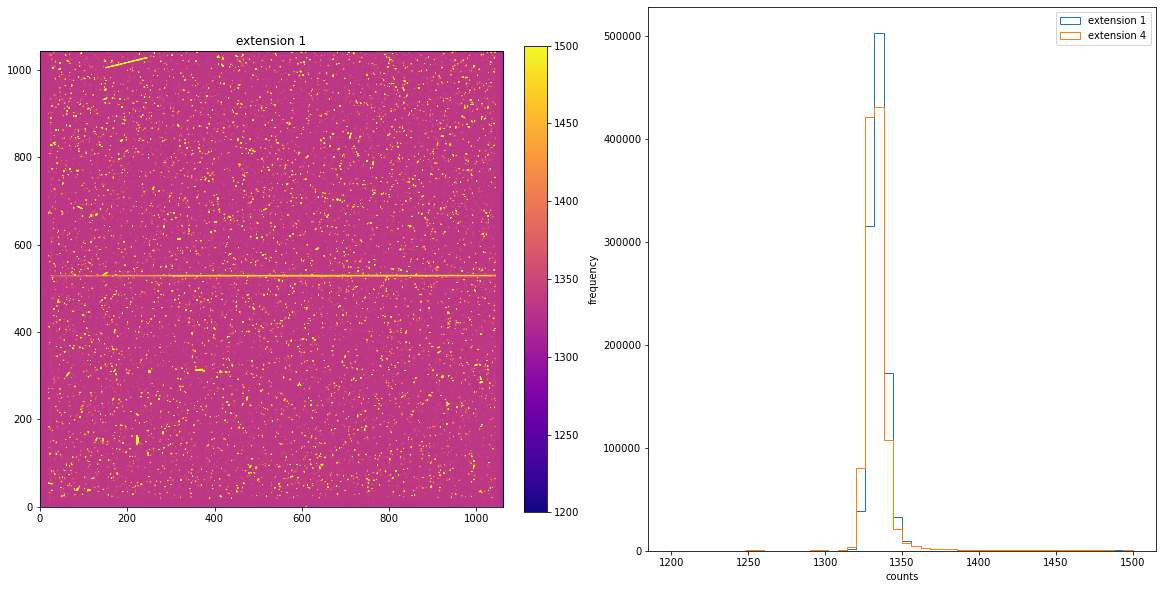

In [7]:
img_hist(raw,[1200,1500])

# 3 DQICORR: Initialize Data Quality File
The DQICORR step is part of basic 2-D image reduction. It takes the initial raw data quality file for the science data and does a bitwise OR with the values in the bad pixel reference file table (BPIXTAB) to create the science data quality file for the following calstis steps. For CCD data, this step also checks saturation by comparing the science extension values with the saturation level from the CCD parameters table(CCDTAB). It also flags the regions of the CCD beyond the edge of the aperture to prevent problems with sky level computation and cosmic ray rejection.

In [8]:
# Turn on the DQICORR switch and perform calibration.
calibrate("DQICORR")


*** CALSTIS-0 -- Version 3.4.2 (19-Jan-2018) ***
Begin    30-Dec-2022 16:22:05 EST

Input    o5f301010_raw.fits
Outroot  ./DQICORR/o5f301010_raw.fits
Warning  WAVECAL was specified, but WAVECORR is not PERFORM.

*** CALSTIS-1 -- Version 3.4.2 (19-Jan-2018) ***
Begin    30-Dec-2022 16:22:16 EST
Input    o5f301010_raw.fits
Output   ./DQICORR/o5f301010_flt.fits
OBSMODE  ACCUM
APERTURE 52X0.2
OPT_ELEM G430L
DETECTOR CCD

Imset 1  Begin 16:22:17 EST

CCDTAB   oref$0841734eo_ccd.fits
CCDTAB   PEDIGREE=INFLIGHT 01/05/1999 01/05/1999
CCDTAB   DESCRIP =Updated readnoise values-------------------------------------------
CCDTAB   DESCRIP =Proposal 8057, by I. Dashevsky & P. Goudfrooij

DQICORR  PERFORM
DQITAB   oref$h1v11475o_bpx.fits
DQITAB   PEDIGREE=GROUND
DQITAB   DESCRIP =Prel. Ground Calib
DQICORR  COMPLETE

ATODCORR OMIT

BLEVCORR OMIT
         Uncertainty array initialized, readnoise=3.99, gain=1, bias=1329

BIASCORR OMIT

DARKCORR OMIT

FLATCORR OMIT

SHADCORR OMIT

PHOTCORR OMIT

STATF

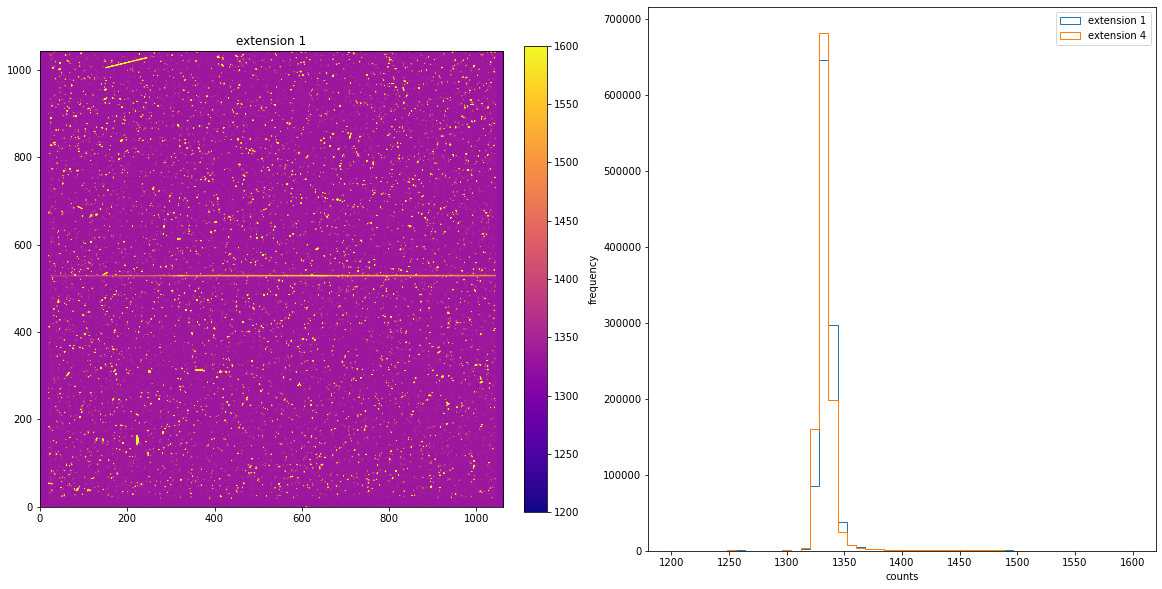

In [9]:
img_hist("./DQICORR/o5f301010_flt.fits",[1200,1600])

# 4 BLEVCORR: Large Scale Bias & Overscan Subtraction
The BLEVCORR step is part of basic 2-D image reduction for CCD data only. This step subtracts the electronic bias level for each line of the CCD image and trims the overscan regions off of the input image, leaving only the exposed portions of the image. 

Because the electronic bias level can vary with time and temperature, its value is determined from the overscan region in the particular exposure being processed. This bias is applied equally to real pixels (main detector and physical overscan) and the virtual overscan region (pixels that don't actually exist, but are recorded when the detector clocks out extra times after reading out all the parallel rows). A raw STIS CCD image in full frame unbinned mode has 19 leading and trailing columns of serial physical overscan in the AXIS1 (x direction), and 20 rows of virtual overscan in the AXIS2 (y direction); therefore the size of the uncalibrated and unbinned full framge CCD image is 1062(serial) $\times$ 1044(parallel) pixels, with 1024 * 1024 exposed science pixels.
<center>
    <img src=figures/CCD_overscan.jpg width ="400">
</center>

The electronic bias level is subtracted line-by-line. An initial value of electronic bias level is determined for each line of the image using the serial and parallel overscans, and a straight line is fitted to the bias as a function of image line. The intial electronic bias for each line is determined by taking the median of a predetermined subset of the trailing serial overscan pixels, which currently includes most trailing overscan region except the first and last three pixels, and pixels flagged with bad data quality flags. The actual overscan bias subtracted from the image is the value of the linear fit at a specific image line. The mean value of all overscan levels is written to the output SCI extension header as MEANBLEV.

THE BLEVCORR step also trims the image of overscan. The size of the overscan regions depend on binning and whether the image if full frame or a subimage, and the locations of the overscan regions depend on which amplifier was used for readout. The number of pixels trimmed during CCD bias level correction on each side is given in the following table.
<center>
    <img src=figures/pixels_trimmed.jpg width ="400">
</center>

In [10]:
# Turn on the BLEVCORR switch and perform calibration.
calibrate("BLEVCORR")


*** CALSTIS-0 -- Version 3.4.2 (19-Jan-2018) ***
Begin    30-Dec-2022 16:22:17 EST

Input    o5f301010_raw.fits
Outroot  ./BLEVCORR/o5f301010_raw.fits
Warning  WAVECAL was specified, but WAVECORR is not PERFORM.

*** CALSTIS-1 -- Version 3.4.2 (19-Jan-2018) ***
Begin    30-Dec-2022 16:22:17 EST
Input    o5f301010_raw.fits
Output   ./BLEVCORR/o5f301010_flt.fits
OBSMODE  ACCUM
APERTURE 52X0.2
OPT_ELEM G430L
DETECTOR CCD

Imset 1  Begin 16:22:18 EST

CCDTAB   oref$0841734eo_ccd.fits
CCDTAB   PEDIGREE=INFLIGHT 01/05/1999 01/05/1999
CCDTAB   DESCRIP =Updated readnoise values-------------------------------------------
CCDTAB   DESCRIP =Proposal 8057, by I. Dashevsky & P. Goudfrooij

DQICORR  PERFORM
DQITAB   oref$h1v11475o_bpx.fits
DQITAB   PEDIGREE=GROUND
DQITAB   DESCRIP =Prel. Ground Calib
DQICORR  COMPLETE

ATODCORR OMIT

BLEVCORR PERFORM
         Bias level from overscan has been subtracted; \
         mean of bias levels subtracted was 1330.96.
BLEVCORR COMPLETE
         Uncertainty a

Show the image and science data distribution histogram in the same way as _raw data. Notice here that there aren't many pixels with counts between 1200 and 1600. This is because the electronic bias level is subtracted from the image.

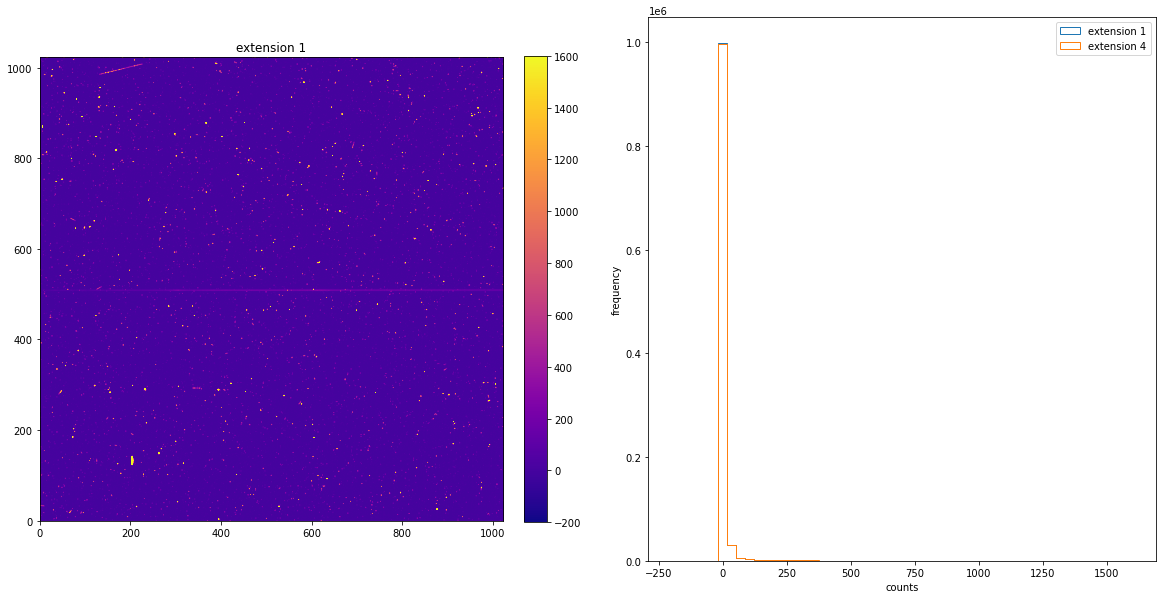

In [11]:
img_hist("./BLEVCORR/o5f301010_flt.fits",[-200,1600])

Now plot the image and histogram again, but with range between -200 and 200. As the histogram shows, the distribution is centered around zero, which means the BLEVCORR is the calibration step that leads to negative counts in the SCI extension.

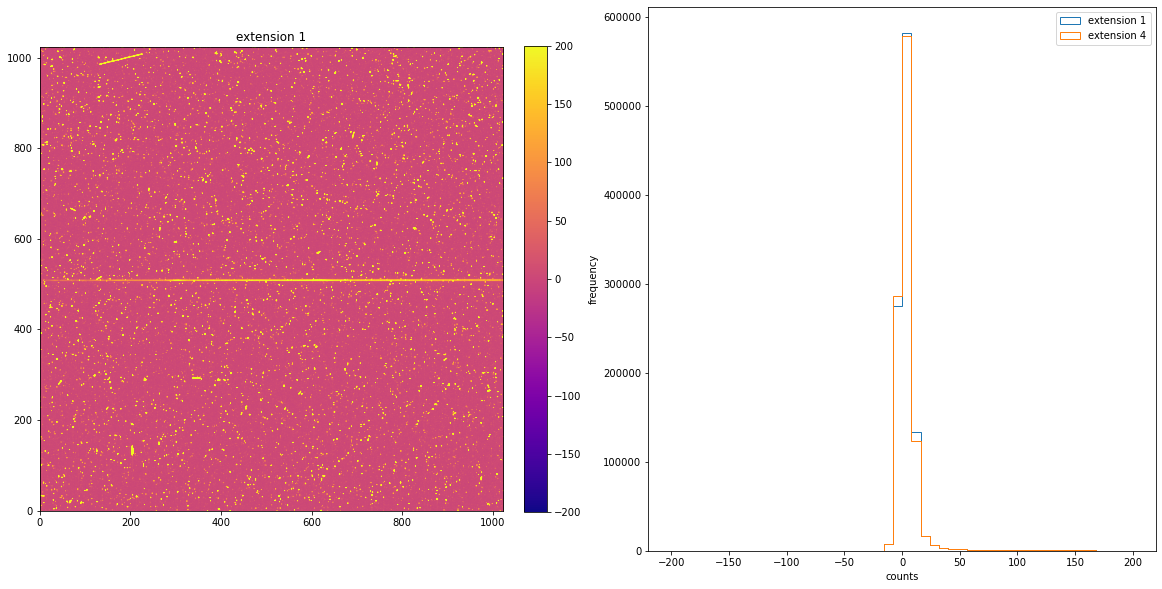

In [12]:
img_hist("./BLEVCORR/o5f301010_flt.fits",[-200,200])

Since the SCI data distribution is centered at 0, we can use another colormap to better visualize the image. The RdBu_r color map is a diverging map with white in the middle, red on the positive direction, and blue on the negative direction (as shown in the color bar). The majority of the image is white and red indicates that most pixels have positive counts, which is consistent with the histogram.

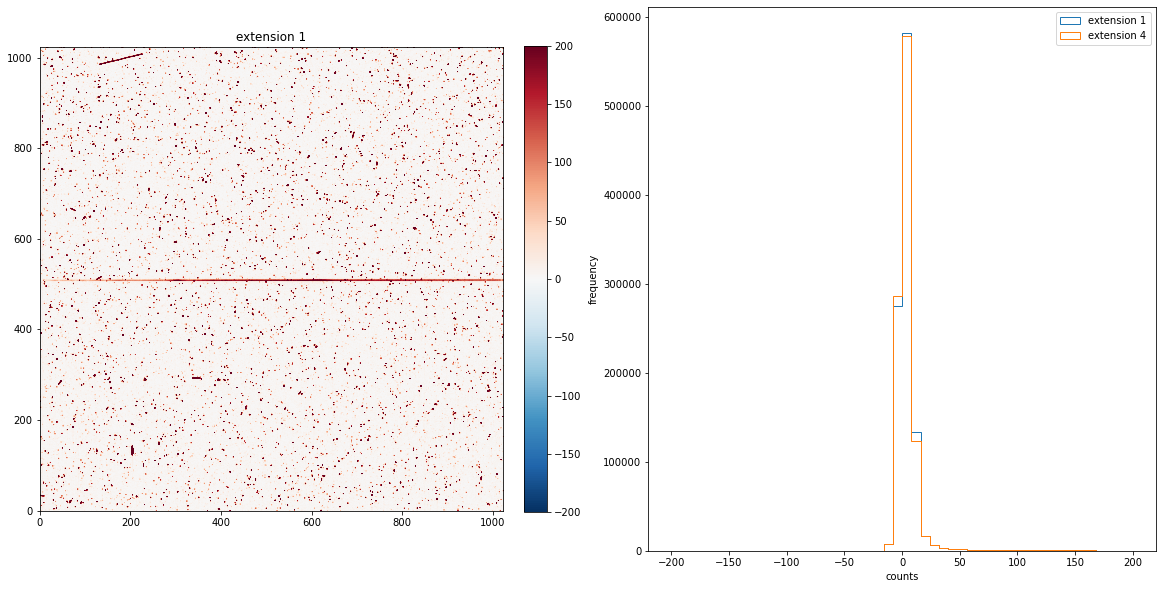

In [13]:
img_hist("./BLEVCORR/o5f301010_flt.fits",[-200,200],color="RdBu_r")

# 5 BIASCORR: Small Scale Bias Subtraction
The BIASCORR step is part of basic 2-D image reduction for CCD data only. This step removes 2-D stationary pattern in the electronic zero point of each CCD readout by subtracting a bias reference image. Separate bias files are used for different values of binning and for different values of gain. Pixels marked with bad data quality flags are also flagged in the science data quality image.

In [14]:
# Turn on the BIASCORR switch and perform calibration.
calibrate("BIASCORR")


*** CALSTIS-0 -- Version 3.4.2 (19-Jan-2018) ***
Begin    30-Dec-2022 16:22:19 EST

Input    o5f301010_raw.fits
Outroot  ./BIASCORR/o5f301010_raw.fits
Warning  WAVECAL was specified, but WAVECORR is not PERFORM.

*** CALSTIS-1 -- Version 3.4.2 (19-Jan-2018) ***
Begin    30-Dec-2022 16:22:19 EST
Input    o5f301010_raw.fits
Output   ./BIASCORR/o5f301010_flt.fits
OBSMODE  ACCUM
APERTURE 52X0.2
OPT_ELEM G430L
DETECTOR CCD

Imset 1  Begin 16:22:19 EST

CCDTAB   oref$0841734eo_ccd.fits
CCDTAB   PEDIGREE=INFLIGHT 01/05/1999 01/05/1999
CCDTAB   DESCRIP =Updated readnoise values-------------------------------------------
CCDTAB   DESCRIP =Proposal 8057, by I. Dashevsky & P. Goudfrooij

DQICORR  PERFORM
DQITAB   oref$h1v11475o_bpx.fits
DQITAB   PEDIGREE=GROUND
DQITAB   DESCRIP =Prel. Ground Calib
DQICORR  COMPLETE

ATODCORR OMIT

BLEVCORR PERFORM
         Bias level from overscan has been subtracted; \
         mean of bias levels subtracted was 1330.96.
BLEVCORR COMPLETE
         Uncertainty a

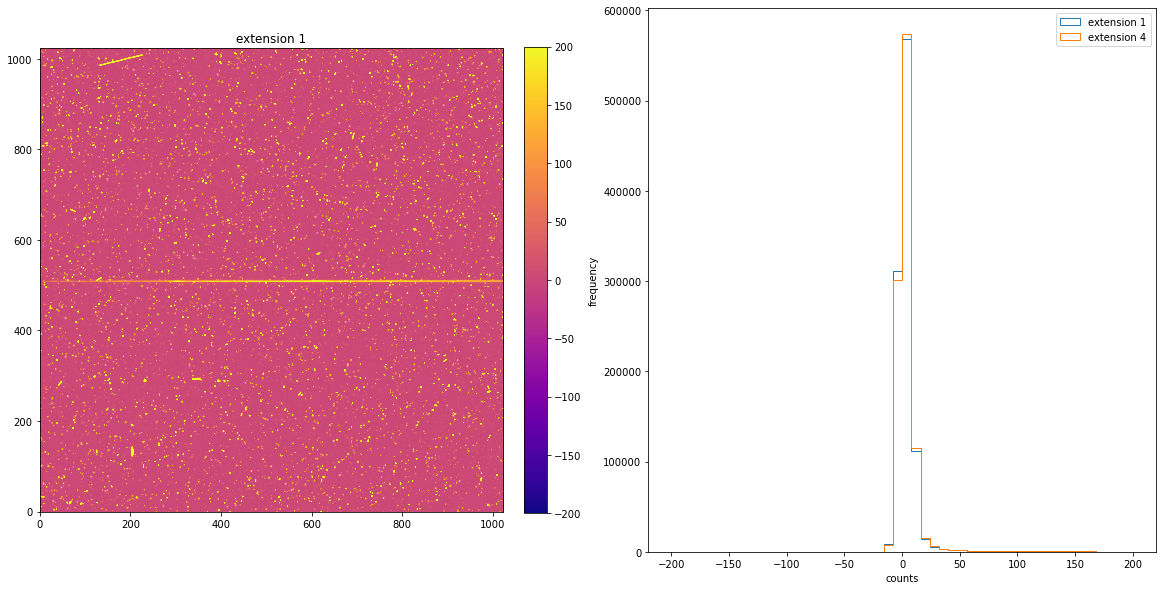

In [15]:
img_hist("./BIASCORR/o5f301010_flt.fits",[-200,200])

# 6 CRCORR: Cosmic Ray Correction
The CRCORR step is applied to CCD data only. The CCD exposures are split into multiple associated exposures in order to apply an anti-coincidence technique, and the exposures are specified by the number of iterations NRPTEXP or CRSPLIT parameters. The CRCORR step sums the individual CRSPLIT exposures in an associated dataset, producing a single cosmic ray rejected file. The CRCORR contains the following steps:
 - Forms a stack of images to be combined(the CRSPLIT or NRPTEXP exposures in the input file).
 - Forms an initial guess image (minimum or median).
 - Forms a summed CR-rejected image, using the guess image to reject high and low values in the stack, based on sigma and the radius parameter that signifies whether to reject pixels neighboring cosmic ray impacts.
 - Iterates, using different (usually decreasing) rejection thresholds to produce a new guess image at each iteration.
 - Produces a final cosmic ray rejected image (_crj), including science, data quality, and error extensions, which is the sum of the input images. Then updates various header keywords.
 - Flags the data quality arrays of the individual (non-CR-rejected) input files to indicate where an outlier has been found (pixels that were rejected because of cosmic ray hits can be identified by looking for data quality bit = 14 in the _flt file).

In [16]:
# Turn on the CRCORR switch and perform calibration.
calibrate("CRCORR")


*** CALSTIS-0 -- Version 3.4.2 (19-Jan-2018) ***
Begin    30-Dec-2022 16:22:23 EST

Input    o5f301010_raw.fits
Outroot  ./CRCORR/o5f301010_raw.fits
Warning  WAVECAL was specified, but WAVECORR is not PERFORM.

*** CALSTIS-1 -- Version 3.4.2 (19-Jan-2018) ***
Begin    30-Dec-2022 16:22:23 EST
Input    o5f301010_raw.fits
Output   ./CRCORR/o5f301010_blv_tmp.fits
OBSMODE  ACCUM
APERTURE 52X0.2
OPT_ELEM G430L
DETECTOR CCD

Imset 1  Begin 16:22:23 EST

CCDTAB   oref$0841734eo_ccd.fits
CCDTAB   PEDIGREE=INFLIGHT 01/05/1999 01/05/1999
CCDTAB   DESCRIP =Updated readnoise values-------------------------------------------
CCDTAB   DESCRIP =Proposal 8057, by I. Dashevsky & P. Goudfrooij

DQICORR  PERFORM
DQITAB   oref$h1v11475o_bpx.fits
DQITAB   PEDIGREE=GROUND
DQITAB   DESCRIP =Prel. Ground Calib
DQICORR  COMPLETE

ATODCORR OMIT

BLEVCORR PERFORM
         Bias level from overscan has been subtracted; \
         mean of bias levels subtracted was 1330.96.
BLEVCORR COMPLETE
         Uncertainty a

Since the CRCORR step sums the CRSPLIT exposures, now there is only one set of SCI, ERR, and DQ extension in the _crj data file:

In [17]:
fits.info("./CRCORR/o5f301010_crj.fits")

Filename: ./CRCORR/o5f301010_crj.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     246   ()      
  1  SCI           1 ImageHDU       118   (1024, 1024)   float32   
  2  ERR           1 ImageHDU        61   (1024, 1024)   float32   
  3  DQ            1 ImageHDU        44   (1024, 1024)   int16   


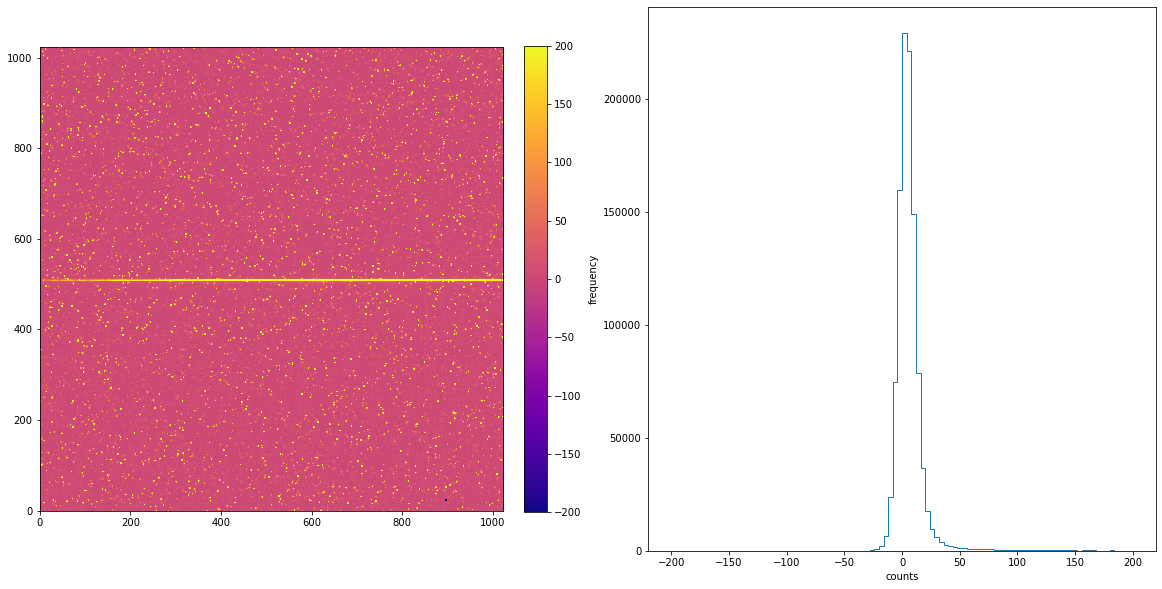

In [18]:
img_hist("./CRCORR/o5f301010_crj.fits",[-200,200])

# 7 DARKCORR: Dark Signal Subtraction
The DARKCORR step is part of basic 2-D image reduction and removes the dark signal (count rate created in the detector in the absence of photons from the sky) from the uncalibrated science image based on reference file. 

The mean of the dark values subtracted is written to the SCI extension header with the keyword MEANDARK. For CCD data, the dark image is multiplied by the exposure time and divided by the ATODGAIN (from the CCD parameters table) before subtracting. The DQ extension is also updated for bad pixels in the dark reference file.

In [19]:
# Turn on the DARKCORR switch and perform calibration.
calibrate("DARKCORR")


*** CALSTIS-0 -- Version 3.4.2 (19-Jan-2018) ***
Begin    30-Dec-2022 16:22:24 EST

Input    o5f301010_raw.fits
Outroot  ./DARKCORR/o5f301010_raw.fits
Warning  WAVECAL was specified, but WAVECORR is not PERFORM.

*** CALSTIS-1 -- Version 3.4.2 (19-Jan-2018) ***
Begin    30-Dec-2022 16:22:24 EST
Input    o5f301010_raw.fits
Output   ./DARKCORR/o5f301010_blv_tmp.fits
OBSMODE  ACCUM
APERTURE 52X0.2
OPT_ELEM G430L
DETECTOR CCD

Imset 1  Begin 16:22:24 EST

CCDTAB   oref$0841734eo_ccd.fits
CCDTAB   PEDIGREE=INFLIGHT 01/05/1999 01/05/1999
CCDTAB   DESCRIP =Updated readnoise values-------------------------------------------
CCDTAB   DESCRIP =Proposal 8057, by I. Dashevsky & P. Goudfrooij

DQICORR  PERFORM
DQITAB   oref$h1v11475o_bpx.fits
DQITAB   PEDIGREE=GROUND
DQITAB   DESCRIP =Prel. Ground Calib
DQICORR  COMPLETE

ATODCORR OMIT

BLEVCORR PERFORM
         Bias level from overscan has been subtracted; \
         mean of bias levels subtracted was 1330.96.
BLEVCORR COMPLETE
         Uncertain

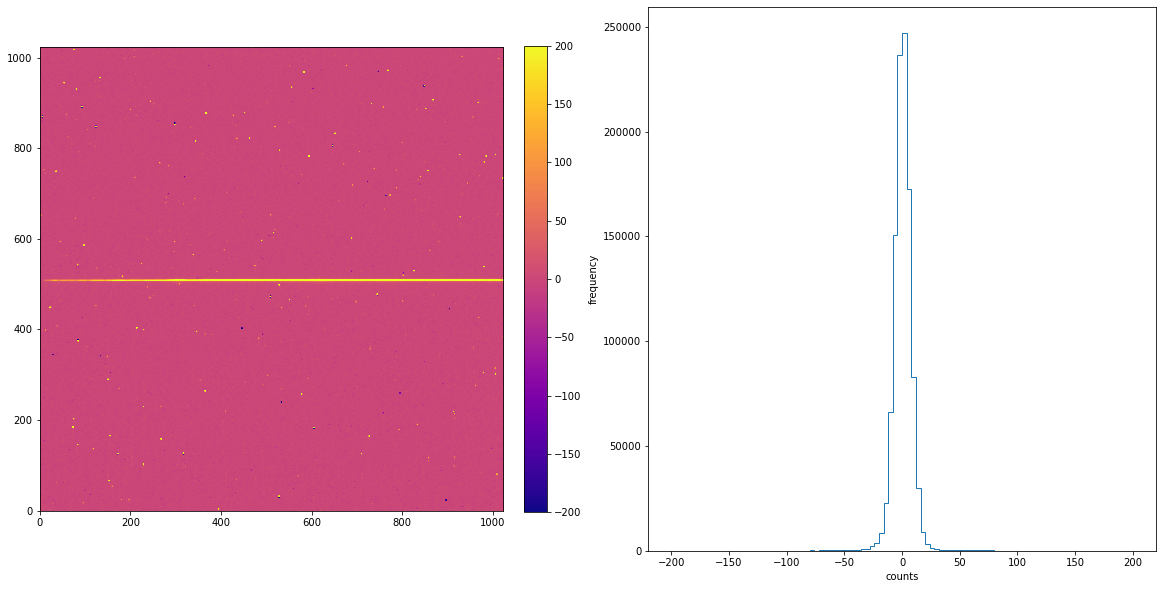

In [20]:
img_hist("./DARKCORR/o5f301010_crj.fits",[-200,200])

# 8 FLATCORR: Flat Field Correction
The FLATCORR step is part of basic 2-D image reduction and corrects for pixel-to-pixel and large scale sensitivity gradients across the detector by dividing the data by a flat field image. The _flt image is created from 3 reference files:
 - PFLTFILE: configuration dependent pixel-to-pixel _flt image that removes large scale sensitivity variations.
 - DFLTFILE: changes in the small scale flat field response relative to the PFLTFILE.
 - LFLTFILE: large scale sensitivity variation across the detector.
 
Calstis creates a single _flt image from these three files, then divides the science image by the combined flat field image. To create such image, calstis first expands LFLTFILE to full format using bilinear interpolation. The DFLTFILE and LFLTFILE are then multiplied together. The DQ extension is updated to reflect bad pixels in the reference files, and the ERR extension is updated to reflect the application of the flat. Blank and “N/A” values of PFLTFILE, DFLTFILE, or LFLTFILE in the science data’s header indicate that type of flat is not to be used.

In [21]:
# Turn on the FLATCORR switch and perform calibration.
calibrate("FLATCORR")


*** CALSTIS-0 -- Version 3.4.2 (19-Jan-2018) ***
Begin    30-Dec-2022 16:22:29 EST

Input    o5f301010_raw.fits
Outroot  ./FLATCORR/o5f301010_raw.fits
Warning  WAVECAL was specified, but WAVECORR is not PERFORM.

*** CALSTIS-1 -- Version 3.4.2 (19-Jan-2018) ***
Begin    30-Dec-2022 16:22:29 EST
Input    o5f301010_raw.fits
Output   ./FLATCORR/o5f301010_blv_tmp.fits
OBSMODE  ACCUM
APERTURE 52X0.2
OPT_ELEM G430L
DETECTOR CCD

Imset 1  Begin 16:22:29 EST

CCDTAB   oref$0841734eo_ccd.fits
CCDTAB   PEDIGREE=INFLIGHT 01/05/1999 01/05/1999
CCDTAB   DESCRIP =Updated readnoise values-------------------------------------------
CCDTAB   DESCRIP =Proposal 8057, by I. Dashevsky & P. Goudfrooij

DQICORR  PERFORM
DQITAB   oref$h1v11475o_bpx.fits
DQITAB   PEDIGREE=GROUND
DQITAB   DESCRIP =Prel. Ground Calib
DQICORR  COMPLETE

ATODCORR OMIT

BLEVCORR PERFORM
         Bias level from overscan has been subtracted; \
         mean of bias levels subtracted was 1330.96.
BLEVCORR COMPLETE
         Uncertain

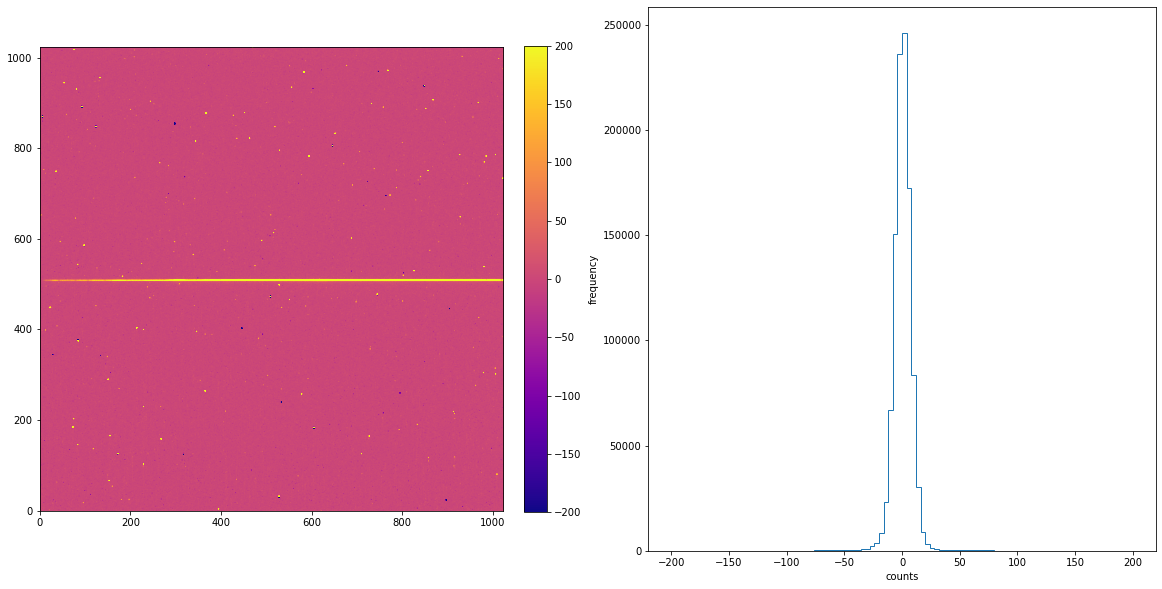

In [22]:
img_hist("./FLATCORR/o5f301010_crj.fits",[-200,200])

# 9 Summary
Now we create 6 subplots when each switches is turned on using the default 'plasma' colormap, and cross compare their differences.

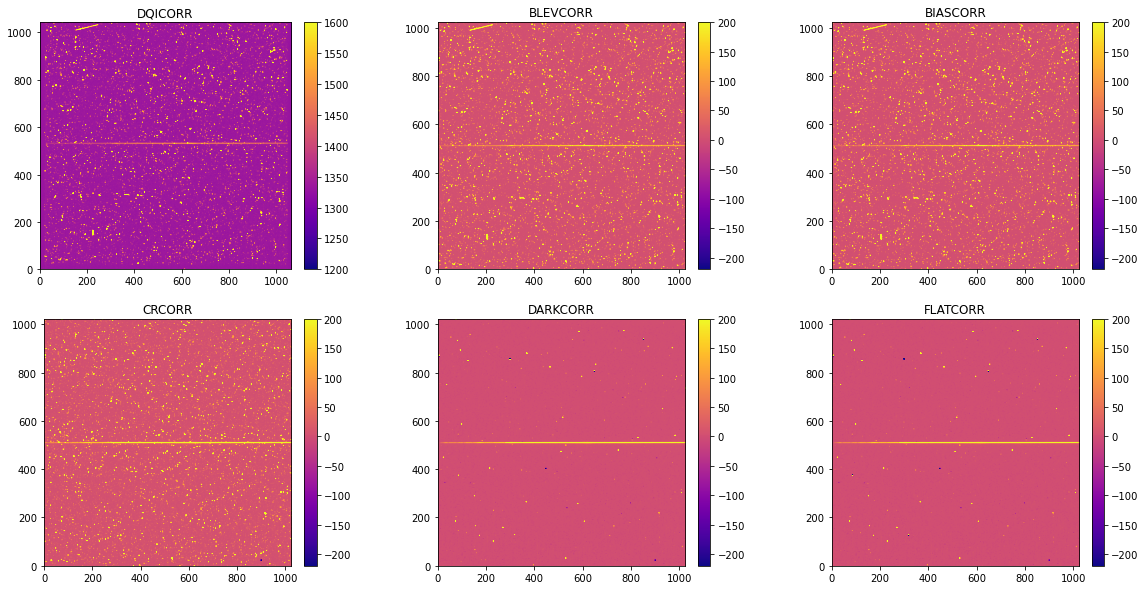

In [23]:
plt.figure(figsize=[20,10])
plt.subplot(2,3,1)
with fits.open("./DQICORR/o5f301010_flt.fits") as hdu:
    ex1 = hdu[1].data
    img = plt.imshow(ex1,origin='lower',cmap="plasma",vmax=1600,vmin=1200)
    plt.colorbar(img,fraction=0.046, pad=0.04)
    plt.title("DQICORR")

plt.subplot(2,3,2)
with fits.open("./BLEVCORR/o5f301010_flt.fits") as hdu:
    ex1 = hdu[1].data
    img = plt.imshow(ex1,origin='lower',cmap="plasma",vmax=-200,vmin=200)
    plt.colorbar(img,fraction=0.046, pad=0.04)
    plt.title("BLEVCORR")
    
plt.subplot(2,3,3)
with fits.open("./BIASCORR/o5f301010_flt.fits") as hdu:
    ex1 = hdu[1].data
    img = plt.imshow(ex1,origin='lower',cmap="plasma",vmax=-200,vmin=200)
    plt.colorbar(img,fraction=0.046, pad=0.04)
    plt.title("BIASCORR")
    
plt.subplot(2,3,4)
with fits.open("./CRCORR/o5f301010_crj.fits") as hdu:
    ex1 = hdu[1].data
    img = plt.imshow(ex1,origin='lower',cmap="plasma",vmax=-200,vmin=200)
    plt.colorbar(img,fraction=0.046, pad=0.04)
    plt.title("CRCORR")
    
plt.subplot(2,3,5)
with fits.open("./DARKCORR/o5f301010_crj.fits") as hdu:
    ex1 = hdu[1].data
    img = plt.imshow(ex1,origin='lower',cmap="plasma",vmax=-200,vmin=200)
    plt.colorbar(img,fraction=0.046, pad=0.04)
    plt.title("DARKCORR")
    
plt.subplot(2,3,6)
with fits.open("./FLATCORR/o5f301010_crj.fits") as hdu:
    ex1 = hdu[1].data
    img = plt.imshow(ex1,origin='lower',cmap="plasma",vmax=-200,vmin=200)
    plt.colorbar(img,fraction=0.046, pad=0.04)
    plt.title("FLATCORR")


---
## About this Notebook <a class="tocSkip">
**Author:** [Keyi Ding](kding@stsci.edu)

**Updated On:** 2022-08-26


> *This tutorial was generated to be in compliance with the [STScI style guides](https://github.com/spacetelescope/style-guides) and would like to cite the [Jupyter guide](https://github.com/spacetelescope/style-guides/blob/master/templates/example_notebook.ipynb) in particular.*
## Citations <a class="tocSkip">

If you use `astropy`, `matplotlib`, `astroquery`, or `numpy` for published research, please cite the
authors. Follow these links for more information about citations:

* [Citing `astropy`/`numpy`/`matplotlib`](https://www.scipy.org/citing.html)
* [Citing `astroquery`](https://astroquery.readthedocs.io/en/latest/)

---

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 